<h2>A Data Driven Approach to Predicting Chemical Reaction Kinetics: Machine Learning</h2>
<br>
Maneet Goyal<sup>1</sup>, Keren Zhang<sup>2</sup>
<br>
<i><sup>1</sup>School of Civil and Environmental Engineering, <sup>2</sup>School of Chemical and Biomolecular Engineering, Georgia Institute of Technology, Atlanta, GA</i>
<hr>

In [1]:
# Displaying the report
from IPython.display import IFrame
IFrame("Report/Report.pdf", width=1000, height=500)

In [2]:
# Importing Libs/Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Reading data for reaction order classification experiments
# This notebook doesn't perform regression studies for acttivation energy prediction; refer to our report for more details on it.
reac_df = pd.read_excel("MLDataDump/TrainingDataNewSpecies.xlsx", header=0, index_col=0)
print('----- No. of Data points (rows) imported: {} -----'.format(len(reac_df.index)))

----- No. of Data points (rows) imported: 1979 -----


In [4]:
# Filtering subset of the dataframe which has reaction order reported
subset_reac_df = reac_df.query('ReactionOrder >= 0')
print('----- No. of Data points (rows) available for experiments: {} -----'.format(len(subset_reac_df.index)))
subset_reac_df.head(5)

----- No. of Data points (rows) available for experiments: 1962 -----


,Reaction Link,Records,Reactants,Products,Reactants_List,Products_List,Reactants_SIDs_List,Products_SIDs_List,Products_Available,Status_50,Status_75,Status_100,ReactionOrder,ActivationEnergy,ReactantCID,ProductCID,FeatureVector
RID,,,,,,,,,,,,,,,,,
776,http://kinetics.nist.gov/kinetics/ReactionSear...,2,Â·CH2 + Â·CH2,C2H2 + HÂ· + HÂ·,"['·CH2', '·CH2']","['C2H2', 'H·', 'H·']","[10972, 10972]","[3537, 8457, 8457]",True,True,True,True,2.0,46000.0,"[123164, 123164]","[6326, 5362549, 5362549]",[ 0. 0. 0. -1. 0. 0. 0. 0. 0. 0. 0. ...
777,http://kinetics.nist.gov/kinetics/ReactionSear...,3,Â·CH2 + Â·CH2,C2H2 + H2,"['·CH2', '·CH2']","['C2H2', 'H2']","[10972, 10972]","[3537, 7937]",True,True,True,True,2.0,50000.0,"[123164, 123164]","[6326, 783]",[-1. 0. 0. -1. 0. 0. 0. 0. 0. 0. 0. ...
780,http://kinetics.nist.gov/kinetics/ReactionSear...,2,Â·CH2,Â·CH + HÂ·,['·CH2'],"['·CH', 'H·']",[10972],"[10960, 8457]",True,True,True,True,2.0,361500.0,[123164],"[-1, 5362549]",[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
781,http://kinetics.nist.gov/kinetics/ReactionSear...,2,Â·CH2,H2 + C,['·CH2'],"['H2', 'C']",[10972],"[7937, 3419]",True,True,True,True,2.0,257500.0,[123164],"[783, 5462310]",[-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1594,http://kinetics.nist.gov/kinetics/ReactionSear...,1,Â·Cl + Â·CH2,Â·CH + HCl,"['·Cl', '·CH2']","['·CH', 'HCl']","[11174, 10972]","[10960, 8171]",True,True,True,True,2.0,106000.0,"[5360523, 123164]","[-1, 313]",[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...


In [5]:
# Filtering just the columns we need
subset_for_exp = subset_reac_df[['FeatureVector', 'ReactionOrder']]
subset_for_exp.head(5)

,FeatureVector,ReactionOrder
RID,,
776,[ 0. 0. 0. -1. 0. 0. 0. 0. 0. 0. 0. ...,2.0
777,[-1. 0. 0. -1. 0. 0. 0. 0. 0. 0. 0. ...,2.0
780,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,2.0
781,[-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,2.0
1594,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,2.0


In [6]:
# Exploring Class Balance/Distribution and Creating X (featurevector) and y (labels)
X_vec = []
y_labl = []
X_Axis = [0, 1, 2, 3]
Y_Axis = [0]*len(X_Axis)
for rid, rxn in subset_for_exp.iterrows():
        Y_Axis[int(rxn['ReactionOrder'])] = Y_Axis[int(rxn['ReactionOrder'])] + 1
        # Feature vectors got converted to string during our routine; converting them back to Numpy arrays
        row_feat_vec = np.array(rxn['FeatureVector'].strip(' []').replace("\n", "").replace(".", "").split(), dtype=float)
        X_vec.append(row_feat_vec)
        y_labl.append(int(rxn['ReactionOrder']))


In [7]:
# Performing Oversampling
X_ror_vec, y_ror_labl = RandomOverSampler().fit_sample(X_vec, y_labl)
X_smote_vec, y_smote_labl = SMOTE(kind='svm').fit_sample(X_vec, y_labl)
axis_ror = (sorted(Counter(y_ror_labl).items()))
axis_smote = (sorted(Counter(y_smote_labl).items()))

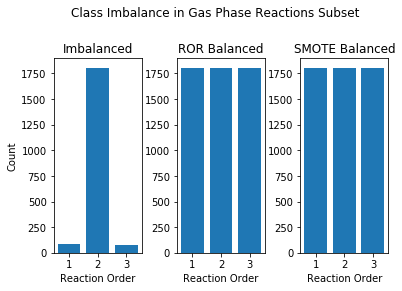

In [8]:
# Plotting Old and New Class Distributions

# Gloabal
fig, ax = plt.subplots()

# Sub1
plt.subplot(131)
plt.bar(X_Axis[1:], Y_Axis[1:])
plt.xlabel('Reaction Order')
plt.ylabel('Count')
plt.title("Imbalanced")

# Sub2
plt.subplot(132)
plt.bar(X_Axis[1:], [ele[1] for ele in axis_ror])
plt.xlabel('Reaction Order')
plt.title("ROR Balanced")

# Sub3
plt.subplot(133)
plt.bar(X_Axis[1:], [ele[1] for ele in axis_smote])
plt.xlabel('Reaction Order')
plt.title("SMOTE Balanced")

# Global
ax.set_yscale('log')
plt.suptitle('Class Imbalance in Gas Phase Reactions Subset')
plt.subplots_adjust(wspace=0.4, top=0.8)
plt.savefig('MLResultFigures/ReactionClasses.png')
plt.show()

In [9]:
# Performing Dimensionality Reduction since we have a 42 dimensions

# Initializing
pca_imbalanced = PCA(svd_solver='full')
pca_ror = PCA(svd_solver='full')
pca_smote = PCA(svd_solver='full')

# Fitting
pca_imbalanced.fit(X_vec)
pca_ror.fit(X_ror_vec)
pca_smote.fit(X_smote_vec)

# Scree Plots Data
scree_imbalanced = pca_imbalanced.explained_variance_ratio_.cumsum()
scree_ror = pca_ror.explained_variance_ratio_.cumsum()
scree_smote = pca_smote.explained_variance_ratio_.cumsum()

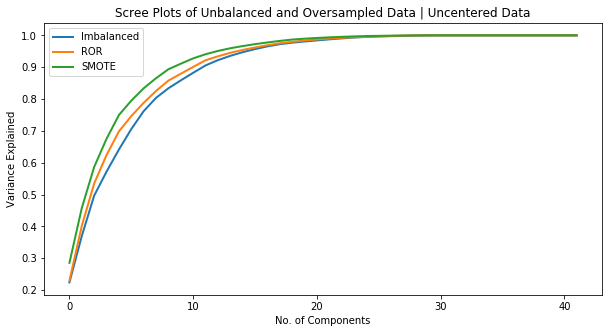

In [16]:
# Plotting Old and Oversampled data's scree plot | Uncentered data

# Gloabal
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(scree_imbalanced, linewidth=2.0, label="Imbalanced")
plt.plot(scree_ror, linewidth=2.0, label="ROR")
plt.plot(scree_smote, linewidth=2.0, label="SMOTE")
plt.xlabel('No. of Components')
plt.ylabel('Variance Explained')
plt.title("Imbalanced")
plt.legend()

plt.title('Scree Plots of Unbalanced and Oversampled Data | Uncentered Data')
plt.savefig('MLResultFigures/ScreePlotsUncentered.png')
plt.show()

The trend in the scree plots is expected as appending rows to a data matrix is expected to either increase the singular values or keep them same as before. This can be proved at least for the largest and the smallest singular values (Refer GVL4 Problem 2.4.9). Hence, the variance explained by the principal components of a matrix  are expected to either increase or remain the same when we compare imbalanced and oversampled data. Note that the `variance explained` or the `eigen values of the covariance matrix` are just the square of the singular values of the centered data matrix.
<hr>
The above discussion reminds us of an important part of PCA, i.e. `CENTERING` (via mean-averaging). IMHO, it is so important that it is perhaps one of the reasons that earned PCA a distinct name; without centering, it might have been referred to as just the `Eigen Value Decomposition` of symmetric matrices. You may have already noticed that centering was not performed over our data, so we have not yet done any PCA. 

In [18]:
# Standarding (centering + scaling) data matrix

# Initializing
centered_unbalanced = StandardScaler()
centered_ror = StandardScaler()
centered_smote = StandardScaler()

# Standardizing
X_vec_std = centered_unbalanced.fit_transform(X_vec)
X_ror_vec_std = centered_unbalanced.fit_transform(X_ror_vec)
X_smote_vec_std = centered_unbalanced.fit_transform(X_smote_vec)

In [19]:
# Performing Dimensionality Reduction since we have a 42 dimensions

# Initializing
pca_imbalanced_std = PCA(svd_solver='full')
pca_ror_std = PCA(svd_solver='full')
pca_smote_std = PCA(svd_solver='full')

# Fitting
pca_imbalanced_std.fit(X_vec_std)
pca_ror_std.fit(X_ror_vec_std)
pca_smote_std.fit(X_smote_vec_std)

# Scree Plots Data
scree_imbalanced_std = pca_imbalanced_std.explained_variance_ratio_.cumsum()
scree_ror_std = pca_ror_std.explained_variance_ratio_.cumsum()
scree_smote_std = pca_smote_std.explained_variance_ratio_.cumsum()

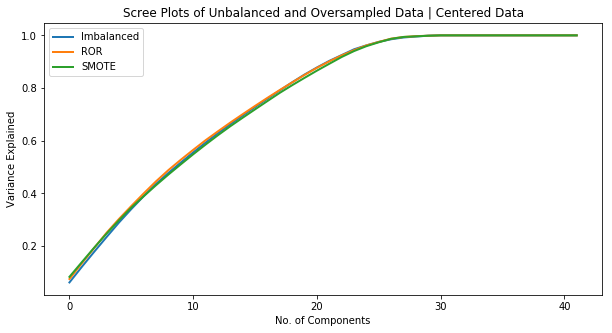

In [20]:
# Plotting Old and Oversampled data's scree plot | Centered data

# Global
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(scree_imbalanced_std, linewidth=2.0, label="Imbalanced")
plt.plot(scree_ror_std, linewidth=2.0, label="ROR")
plt.plot(scree_smote_std, linewidth=2.0, label="SMOTE")
plt.xlabel('No. of Components')
plt.ylabel('Variance Explained')
plt.title("Imbalanced")
plt.legend()

plt.title('Scree Plots of Unbalanced and Oversampled Data | Centered Data')
plt.savefig('MLResultFigures/ScreePlotsCentered.png')
plt.show()

In [43]:
#Classification via Random Forests

# Initializing
clf_unbalanced = RandomForestClassifier(criterion="entropy")
clf_ror = RandomForestClassifier(criterion="entropy")
clf_smote = RandomForestClassifier(criterion="entropy")

# Training and Cross validating
scores_unbalanced = np.mean(cross_val_score(clf_unbalanced, X_vec_std, y_labl, cv=10))
scores_ror = np.mean(cross_val_score(clf_ror, X_ror_vec_std, y_ror_labl, cv=10))
scores_smote = np.mean(cross_val_score(clf_smote, X_smote_vec_std, y_smote_labl, cv=10))

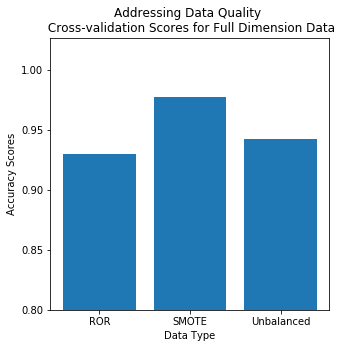

In [46]:
# Plotting Cross validation scores

# Global
fig, ax = plt.subplots(figsize=(5,5))

plt.bar(['Unbalanced', 'ROR', 'SMOTE'], [scores_unbalanced, scores_ror, scores_smote])
plt.xlabel('Data Type')
plt.ylabel('Accuracy Scores')
plt.title('Addressing Data Quality \n Cross-validation Scores for Full Dimension Data')
ax.set_ylim(ymin=0.8)
plt.savefig('MLResultFigures/CVScoreFull.png')
plt.show()

Random Forest Model trained over SMOTE's data is clearly performing the best. Two observations are worth discussing about: <span style="color:gray">model trained over imbalanced data is performing better than that trained over ROR oversampled data</span>; and <span style="color:gray">model trained over SMOTE data is performing better than that trained over ROR oversampled data</span>.